# Modul Pembelajaran: Penerapan dan Penyimpanan Filter Audio dengan Visualisasi Spektrum Frekuensi

#### Pendahuluan

Dalam pengolahan sinyal audio, penggunaan filter adalah teknik yang sangat penting untuk memanipulasi konten frekuensi dalam sinyal. Filter dapat digunakan untuk menghilangkan noise, mengekstrak informasi spesifik, atau mengubah karakteristik suara. Dalam modul ini, kita akan menerapkan tiga jenis filter utama: **Low Pass**, **High Pass**, dan **Bandpass** pada sebuah sinyal audio. Setelah itu, kita akan memvisualisasikan spektrum frekuensi dari sinyal yang telah difilter dan menyimpannya dalam format WAV. 

#### Teori Dasar

- **Low Pass Filter**: Low Pass Filter memungkinkan frekuensi rendah untuk lewat, sementara memblokir frekuensi tinggi. Filter ini digunakan untuk menghilangkan noise frekuensi tinggi atau untuk menghasilkan efek suara yang lebih halus.

- **High Pass Filter**: High Pass Filter melewatkan frekuensi tinggi dan memblokir frekuensi rendah. Filter ini sering digunakan untuk menghilangkan hum atau suara mendengung yang biasanya berada di frekuensi rendah.

- **Bandpass Filter**: Bandpass Filter hanya melewatkan rentang frekuensi tertentu, sementara frekuensi di bawah dan di atas rentang ini diblokir. Filter ini berguna untuk mengekstrak sinyal pada rentang frekuensi tertentu dari sebuah sinyal yang lebih kompleks.

#### Langkah-Langkah dalam Kode

Berikut ini adalah langkah-langkah yang dilakukan dalam kode untuk memproses sinyal audio menggunakan filter, memvisualisasikan spektrum frekuensi, dan menyimpan hasilnya:

### 1. Memuat dan Mempersiapkan Data Audio

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import os
from scipy.signal import butter, filtfilt
import soundfile as sf

# Load dan trim data audio
file_path = os.path.join(os.getcwd(), 'data', 'harvard.wav')

with wave.open(file_path, 'r') as wav_file:
    n_channels = wav_file.getnchannels()
    sampwidth = wav_file.getsampwidth()
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_content = wav_file.readframes(n_frames)
    audio_data = np.frombuffer(audio_content, dtype=np.int16)
    
    # Jika audio stereo, hanya gunakan satu channel
    if n_channels > 1:
        audio_data = audio_data.reshape(-1, n_channels)
        audio_data = audio_data[:, 0]  # Pilih channel pertama



**Penjelasan**:
- **wave.open**: Membuka file WAV dan membaca metadata seperti jumlah channel, sample width, dan framerate.
- **audio_data**: Data audio dibaca sebagai buffer dan diubah menjadi array `numpy` dengan tipe data `int16`. Jika audio stereo, hanya satu channel yang dipilih untuk diproses.
  
### 2. Membuat Fungsi Filter

In [2]:
# Fungsi untuk membuat dan menerapkan filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Frekuensi Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Frekuensi Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Frekuensi Nyquist
    normal_low = lowcut / nyq
    normal_high = highcut / nyq
    b, a = butter(order, [normal_low, normal_high], btype='band', analog=False)
    return b, a

# Terapkan filter
def apply_filter(data, b, a):
    y = filtfilt(b, a, data)
    return y


**Penjelasan**:
- **butter_lowpass, butter_highpass, butter_bandpass**: Fungsi ini membuat filter Butterworth, yang dikenal karena memiliki respons frekuensi yang halus tanpa ripple dalam bandpass-nya. Frekuensi cutoff dan order filter digunakan untuk menentukan karakteristik filter.
- **Frekuensi Nyquist**: Setengah dari frekuensi sampling, digunakan untuk menormalisasi frekuensi cutoff pada desain filter digital.

### 3. Menerapkan Filter pada Data Audio

In [13]:
# Parameter filter
lowcut = 600.0  # Lowcut untuk bandpass dan highpass
highcut = 4000.0  # Highcut untuk bandpass dan lowpass
order = 2

# Filter Low Pass
b, a = butter_lowpass(lowcut, framerate, order=order)
low_passed = apply_filter(audio_data, b, a)

# Filter High Pass
b, a = butter_highpass(highcut, framerate, order=order)
high_passed = apply_filter(audio_data, b, a)

# Filter Bandpass
b, a = butter_bandpass(lowcut, highcut, framerate, order=order)
band_passed = apply_filter(audio_data, b, a)


**Penjelasan**:
- **apply_filter**: Fungsi ini menerapkan filter yang telah dirancang pada data audio menggunakan `filtfilt`, yang menerapkan filter dua kali (maju dan mundur) untuk menghilangkan distorsi fase.
- **Parameter Filter**: Lowcut dan highcut ditentukan untuk masing-masing filter. `Order` filter yang rendah (2) dipilih untuk menghasilkan respons frekuensi yang lebih sederhana.

### 4. Visualisasi Spektrum Frekuensi

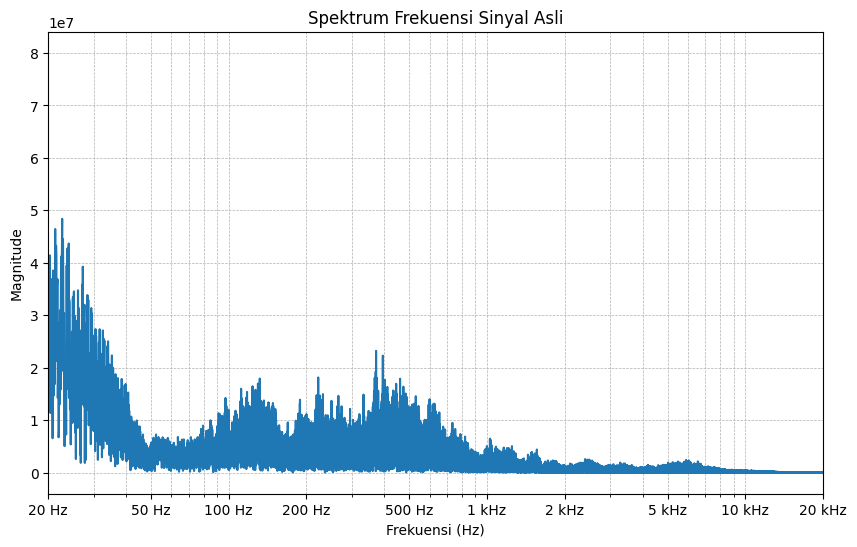

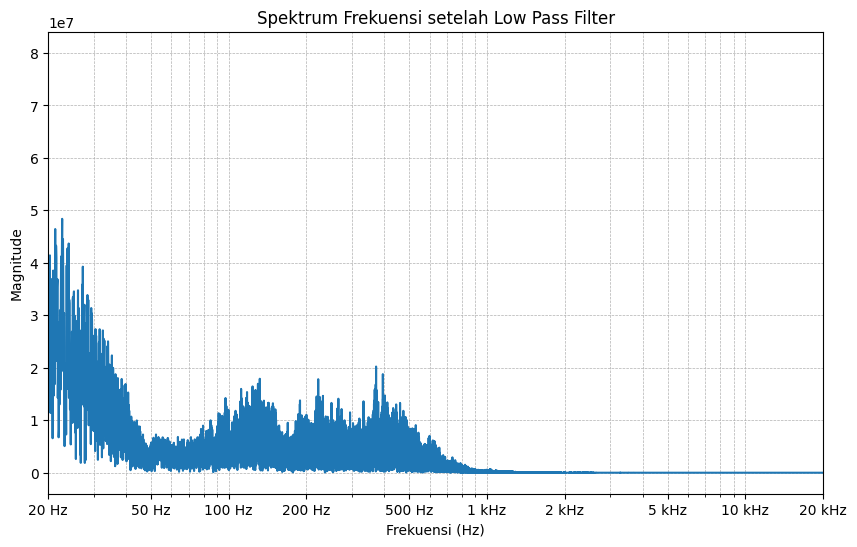

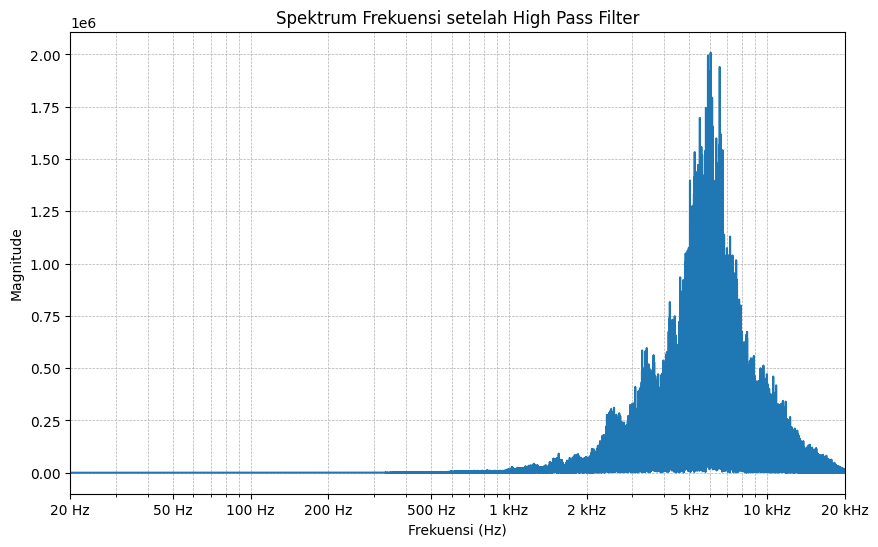

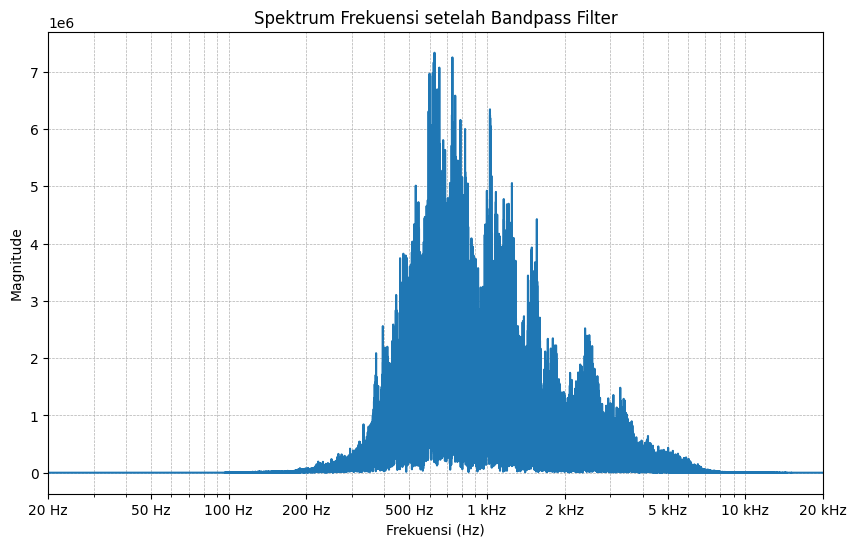

In [14]:
# Fungsi untuk menghitung dan memplot spektrum frekuensi
def plot_frequency_spectrum(data, framerate, title):
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(fft_data), 1 / framerate)
    
    positive_frequencies = frequencies[:len(frequencies) // 2]
    magnitude = np.abs(fft_data[:len(frequencies) // 2])
    
    plt.figure(figsize=(10, 6))
    plt.plot(positive_frequencies, magnitude)
    plt.xscale('log')
    plt.xlim(20, 20000)  # Rentang frekuensi yang relevan untuk audio
    plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], 
               ['20 Hz', '50 Hz', '100 Hz', '200 Hz', '500 Hz', '1 kHz', '2 kHz', '5 kHz', '10 kHz', '20 kHz'])
    plt.title(title)
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Visualisasi spektrum frekuensi dari sinyal asli dan hasil filter
plot_frequency_spectrum(audio_data, framerate, 'Spektrum Frekuensi Sinyal Asli')
plot_frequency_spectrum(low_passed, framerate, 'Spektrum Frekuensi setelah Low Pass Filter')
plot_frequency_spectrum(high_passed, framerate, 'Spektrum Frekuensi setelah High Pass Filter')
plot_frequency_spectrum(band_passed, framerate, 'Spektrum Frekuensi setelah Bandpass Filter')


**Penjelasan**:
- **plot_frequency_spectrum**: Fungsi ini menghitung dan memplot spektrum frekuensi dari data audio menggunakan FFT. Spektrum frekuensi memberikan informasi tentang distribusi energi di berbagai frekuensi dalam sinyal.
- **Spektrum Positif**: Hanya spektrum frekuensi positif yang dipertimbangkan karena spektrum FFT simetris.
- **Logarithmic Scale**: Sumbu x diubah ke skala logaritmik untuk merefleksikan cara persepsi manusia terhadap frekuensi, terutama dalam konteks audio.

### 5. Normalisasi dan Penyimpanan Audio

In [15]:
# Fungsi untuk normalisasi audio sebelum penyimpanan
def normalize_audio(data):
    # Pastikan nilai berada dalam rentang -1.0 hingga 1.0
    data = data / np.max(np.abs(data))
    return data

# Fungsi untuk menyimpan data audio ke file
def save_audio(filename, data, framerate):
    # Normalisasi data
    data = normalize_audio(data)
    # Ubah kembali ke format int16 sebelum disimpan
    data = np.int16(data * 32767)
    
    filename = os.path.join(os.getcwd(), 'output', filename)
    sf.write(filename, data, framerate)

# Simpan audio yang telah difilter dengan normalisasi
save_audio('low_passed.wav', low_passed, framerate)
save_audio('high_passed.wav', high_passed, framerate)
save_audio('band_passed.wav', band_passed, framerate)


**Penjelasan**:
- **normalize_audio**: Fungsi ini menormalkan data audio sehingga nilai amplitudonya berada dalam rentang -1.0 hingga 1.0. Ini penting untuk mencegah clipping saat data diubah kembali ke

 format `int16`.
- **save_audio**: Data audio yang telah difilter dan dinormalisasi kemudian disimpan dalam format WAV dengan konversi kembali ke `int16`. Audio disimpan dalam folder `output` di dalam direktori kerja saat ini.

#### Kesimpulan

Modul ini telah membahas proses penerapan filter Low Pass, High Pass, dan Bandpass pada sinyal audio, serta cara memvisualisasikan spektrum frekuensi hasil filtrasi. Selain itu, Anda juga belajar cara menormalkan dan menyimpan hasil audio yang telah difilter dalam format WAV. Pemahaman ini sangat penting dalam pemrosesan sinyal audio, baik untuk keperluan analisis maupun aplikasi praktis seperti penghapusan noise atau pemrosesan sinyal komunikasi.

---

## Tugas: `ho1`
6. Rekamlah sebuah audio dengan menggunakan handphone anda. Cara anda merekam haruslah sedikit unik:
- Anda harus berbicara selama 20 detik.
- Bacaan / percakapan yang anda rekam haruslah berisi informasi mengenai diri anda, seperti nama, asal daerah, hobi, dll.
- Lakukanlah perekaman di dekat sumber noise statis seperti kipas angin, AC, atau kipas laptop anda.
- Lakukanlah equalisasi pada audio tersebut dengan menggunakan filter low pass, high pass, dan bandpass. Temukan frekuensi cutoff untuk bandpass yang paling sesuai dengan karakteristik audio yang anda rekam.
- Visualisasikan spektrum frekuensi dari audio sebelum di filter dan setelah di filter (dengan ketiga filter yang telah anda buat).

### Ketentuan Penamaan File
```
nim_ho1.ipynb
```

> Saya sudah mendapatkan akses ke server [MOSS Stanford](https://theory.stanford.edu/~aiken/moss/) untuk menggunakan sistem mereka dalam mata kuliah ini untuk mendeteksi code yang "plagiat". Untuk menjamin bahwa code anda tidak terindikasi plagiarisme, silahkan gunakan nama variabel / parameter / dan konfigurasi yang unik dan tidak copy paste. Dan yang terpenting, berusahalah bekerja sendiri. Jika mendapat bantuan baik dari manusia maupun AI / web, segera cantumkan dalam bagian terakhir `ipynb` anda.

### Pengumpulan
- Unggah `.ipynb` ke repositori anda.
- Paste link dari file ke google form pengumpulan tugas
- Export `.ipynb` menjadi `.pdf` dan unggah juga ke google form

Link yang di paste harus mirip dengan format berikut:
```
https://github.com/<username>/<kode_mk>/blob/master/<nim_ho1>.ipynb
```

- *Pastikan repo anda bersifat privat dan anda telah mengundang dosen pengampu ke repositori anda*
- Seluruh tugas untuk ho1 digabung dalam satu file notebook `.ipynb`
- Berikan penjelasan yang sedetail-detailnya untuk setiap bagian eksperimen yang anda lakukan